In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

path = "C:/Users/itataurov.KORECAPITAL/Desktop/ccxt_data/data_parsed/1d/technical/binance/joined/binance_perps_joined.parquet"

df = pd.read_parquet(path, engine='pyarrow')
df = df.sort_values(by=['datetime'])
df.datetime = pd.to_datetime(df.datetime)

In [2]:
# 1) Compute each coin’s true days since listing (using its first-ever timestamp)
first_list = df.groupby('symbol')['datetime'].transform('min')
df['days_since_list'] = (df['datetime'] - first_list).dt.days
df['signal'] = np.where(df['days_since_list'] < 100, -1, 0)

# Event study

We want to compare the avg cumulative return of a newly listed coin and compare it the avg cumulative return of all coins for the same period.

In [3]:
# 2) Filter raw data to only the last n months
n_months_ago = pd.Timestamp.now() - pd.DateOffset(months=36)
df = df[df['datetime'] >= n_months_ago].copy()

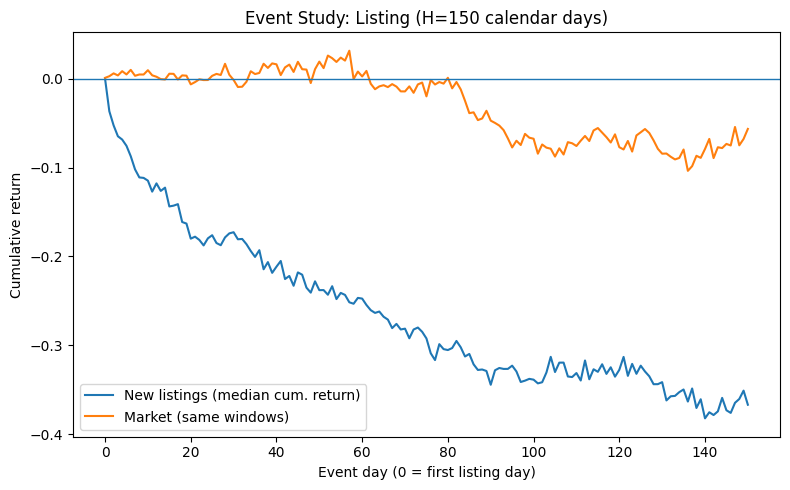

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Load & prep ---
path = "C:/Users/itataurov.KORECAPITAL/Desktop/ccxt_data/data_parsed/1d/technical/binance/joined/binance_perps_joined.parquet"
df = pd.read_parquet(path, engine='pyarrow')
df = df.sort_values('datetime')
df['datetime'] = pd.to_datetime(df['datetime'])

# Pivot to Prices (Date x Symbol)
prices = df.pivot(index='datetime', columns='symbol', values='close').sort_index()

# Daily returns
rets = prices.pct_change().dropna(how='all')

# Listing dates per symbol (first date we have a price)
first_dates = prices.apply(lambda s: s.first_valid_index())

# --- Parameters ---
H = 150 # horizon in calendar days after listing to track
min_len = 0  # require at least 10 days to include a coin (keep it simple)

# Containers for event-aligned cumulative returns
event_curves = []
benchmark_curves = []

for sym, start_date in first_dates.items():
    if pd.isna(start_date):
        continue

    # Select calendar window [start_date, start_date+H]
    end_date = start_date + pd.Timedelta(days=H)
    window_idx = rets.index[(rets.index >= start_date) & (rets.index <= end_date)]
    if len(window_idx) < min_len:
        continue

    # Coin-specific returns over the window (fill NA with 0 for simplicity)
    coin_r = rets.loc[window_idx, sym].fillna(0.0)
    coin_cum = (1.0 + coin_r).cumprod() - 1.0
    # Reindex to event time: 0..T-1
    coin_cum.index = np.arange(len(coin_cum))
    event_curves.append(coin_cum)

    # Equal-weight market over the *same calendar dates* as a benchmark
    mkt_r = rets.loc[window_idx].mean(axis=1, skipna=True)
    mkt_cum = (1.0 + mkt_r).cumprod() - 1.0
    mkt_cum.index = np.arange(len(mkt_cum))
    benchmark_curves.append(mkt_cum)

# Average across events (align by inner index)
if event_curves and benchmark_curves:
    # Concatenate with axis=1 and take mean row-wise
    avg_event = pd.concat(event_curves, axis=1).median(axis=1)
    avg_bench = pd.concat(benchmark_curves, axis=1).median(axis=1)
else:
    raise ValueError("No valid events found. Check data coverage or adjust H/min_len.")

# --- Plot ---
plt.figure(figsize=(8,5))
plt.plot(avg_event.index, avg_event.values, label="New listings (median cum. return)")
plt.plot(avg_bench.index, avg_bench.values, label="Market (same windows)")
plt.axhline(0, linewidth=1)
plt.xlabel("Event day (0 = first listing day)")
plt.ylabel("Cumulative return")
plt.title(f"Event Study: Listing (H={H} calendar days)")
plt.legend()
plt.tight_layout()
plt.show()


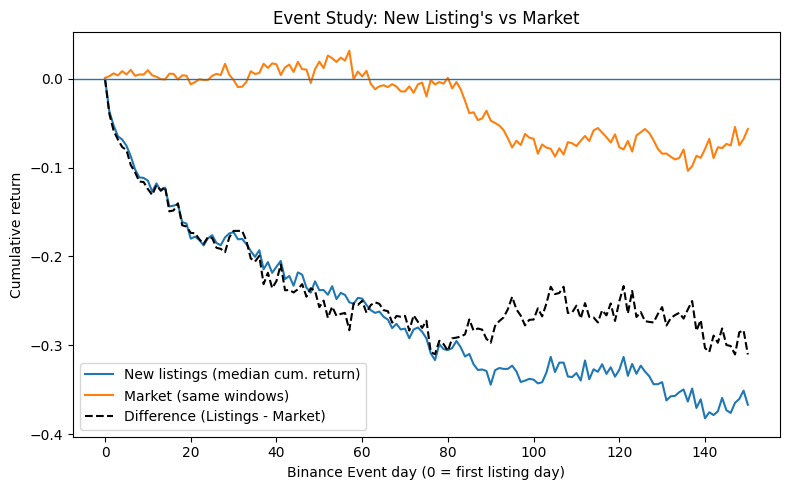

In [5]:
# --- Plot ---
plt.figure(figsize=(8,5))
plt.plot(avg_event.index, avg_event.values, label="New listings (median cum. return)")
plt.plot(avg_bench.index, avg_bench.values, label="Market (same windows)")

# Difference: new listings minus market
diff = avg_event - avg_bench
plt.plot(diff.index, diff.values, label="Difference (Listings - Market)", color="black", linestyle="--")

plt.axhline(0, linewidth=1)
plt.xlabel("Binance Event day (0 = first listing day)")
plt.ylabel("Cumulative return")
plt.title(f"Event Study: New Listing's vs Market")
plt.legend()
plt.tight_layout()
plt.show()

# Equal weight backtest, rolling hedge

C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_13364\4021068430.py:28: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df["weight"] = df.groupby("datetime", group_keys=False).apply(_equal_long)


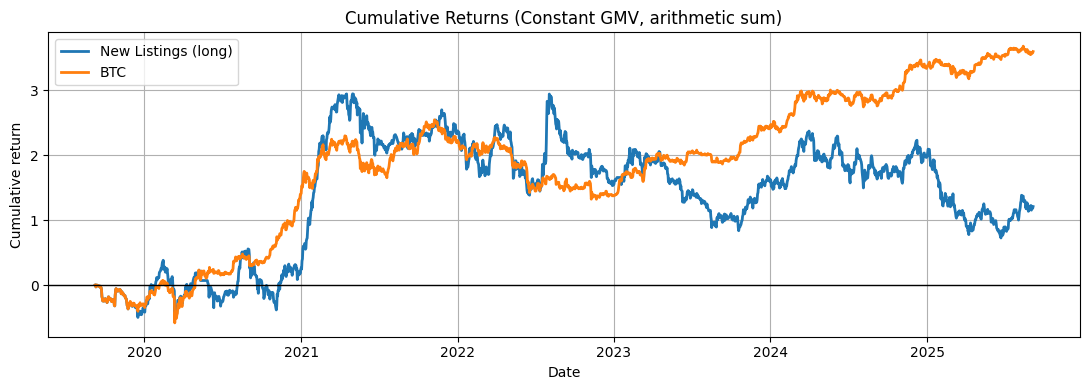

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------------- 1. Load & prep ----------------
df = pd.read_parquet(
    "C:/Users/itataurov.KORECAPITAL/Desktop/ccxt_data/data_parsed/1d/technical/binance/joined/binance_perps_joined.parquet",
    engine="pyarrow"
)
df = df.sort_values(["datetime", "symbol"]).copy()
df["datetime"] = pd.to_datetime(df["datetime"])

# ---------------- 2. Days since listing ----------------
first_list = df.groupby("symbol")["datetime"].transform("min")
df["days_since_list"] = (df["datetime"] - first_list).dt.days

# ---------------- 3. Returns ----------------
if "ret" not in df.columns:
    df["ret"] = df.groupby("symbol")["close"].pct_change()

# ---------------- 4. Equal-weight long signals ----------------
# Rule: long all coins within 80 days of listing (was -1 before, now +1/n)
def _equal_long(day):
    longs = day["days_since_list"] < 80
    n = longs.sum()
    return pd.Series(np.where(longs, 1.0 / n, 0.0) if n > 0 else np.zeros(len(day)), index=day.index)

df["weight"] = df.groupby("datetime", group_keys=False).apply(_equal_long)

# ---------------- 5. Wide pivot ----------------
weights = df.pivot(index="datetime", columns="symbol", values="weight").fillna(0.0)
rets    = df.pivot(index="datetime", columns="symbol", values="ret").fillna(0.0)

# Hard-code BTC
BTC_COL = "BTC"
if BTC_COL not in rets.columns:
    raise ValueError(f"{BTC_COL} not found in symbols: {rets.columns[:10].tolist()}...")

# ---------------- 6. Portfolio returns ----------------
# Use yesterday's weights × today's returns (no look-ahead)
alt_port_ret = (weights.shift(1) * rets).sum(axis=1).rename("alt_port_ret")
btc_ret = rets[BTC_COL].rename("btc_ret")
btc_ret = btc_ret

# ---------------- 7. Cumulative arithmetic returns ----------------
cum_alt = alt_port_ret.cumsum().rename("New Listings (equal weight)")
cum_btc = btc_ret.cumsum().rename("BTC")

# ---------------- 8. Plot ----------------
plt.figure(figsize=(11, 4))
plt.plot(cum_alt.index, cum_alt.values, label="New Listings (long)", lw=2)
plt.plot(cum_btc.index, cum_btc.values, label="BTC", lw=2)
plt.axhline(0, lw=1, color="black")
plt.title("Cumulative Returns (Constant GMV, arithmetic sum)")
plt.xlabel("Date")
plt.ylabel("Cumulative return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


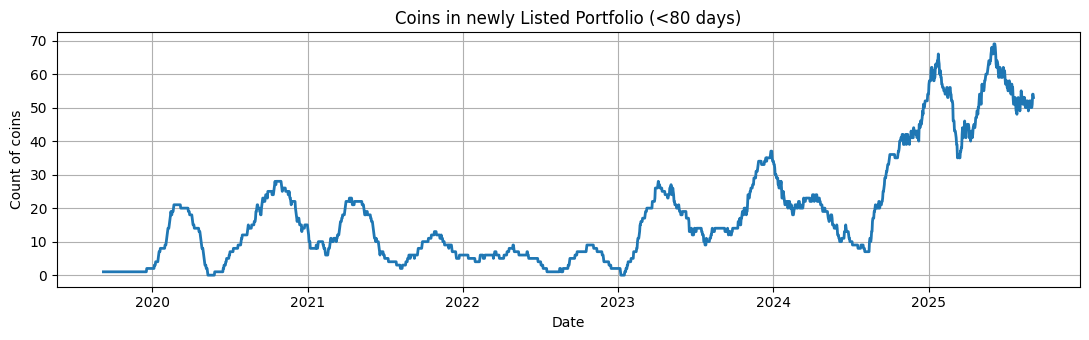

In [7]:
# ---------------- 9. Count of coins in new-listings portfolio ----------------
coin_count = (df['days_since_list'] < 80).groupby(df['datetime']).sum()
coin_count = coin_count.rename("newly_listed_count")

plt.figure(figsize=(11, 3.5))
plt.plot(coin_count.index, coin_count.values, lw=2)
plt.title("Coins in newly Listed Portfolio (<80 days)")
plt.xlabel("Date")
plt.ylabel("Count of coins")
plt.grid(True)
plt.tight_layout()
plt.show()


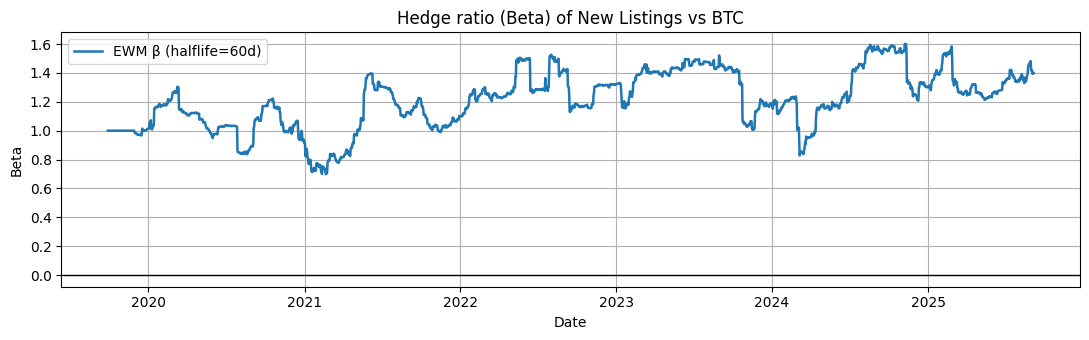

In [8]:
# ---------------- 9. Rolling beta (EWM halflife=60 days) ----------------
HL = 60
MINP = 20  # minimum periods for stability

cov_ab = alt_port_ret.ewm(halflife=HL, adjust=False, min_periods=MINP).cov(btc_ret)
var_b  = btc_ret.ewm(halflife=HL, adjust=False, min_periods=MINP).var()

beta_raw = cov_ab / var_b
beta = beta_raw.shift(1).rename("beta")  # lag 1 day to avoid look-ahead

# ---------------- 10. Plot beta ----------------
plt.figure(figsize=(11, 3.5))
plt.plot(beta.index, beta.values, lw=1.8, label=f"EWM β (halflife={HL}d)")
plt.axhline(0, color="black", lw=1)
plt.title("Hedge ratio (Beta) of New Listings vs BTC")
plt.xlabel("Date")
plt.ylabel("Beta")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<Axes: title={'center': 'Cumulative Returns: Hedged New Listings vs BTC'}, xlabel='datetime'>

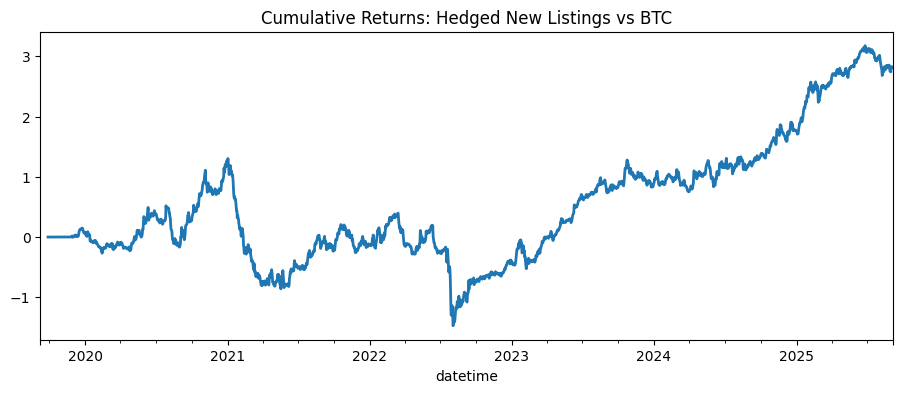

In [9]:
(- alt_port_ret + btc_ret * beta ).cumsum().rename("Hedged New Listings (equal weight)").plot(figsize=(11,4), lw=2, title="Cumulative Returns: Hedged New Listings vs BTC")

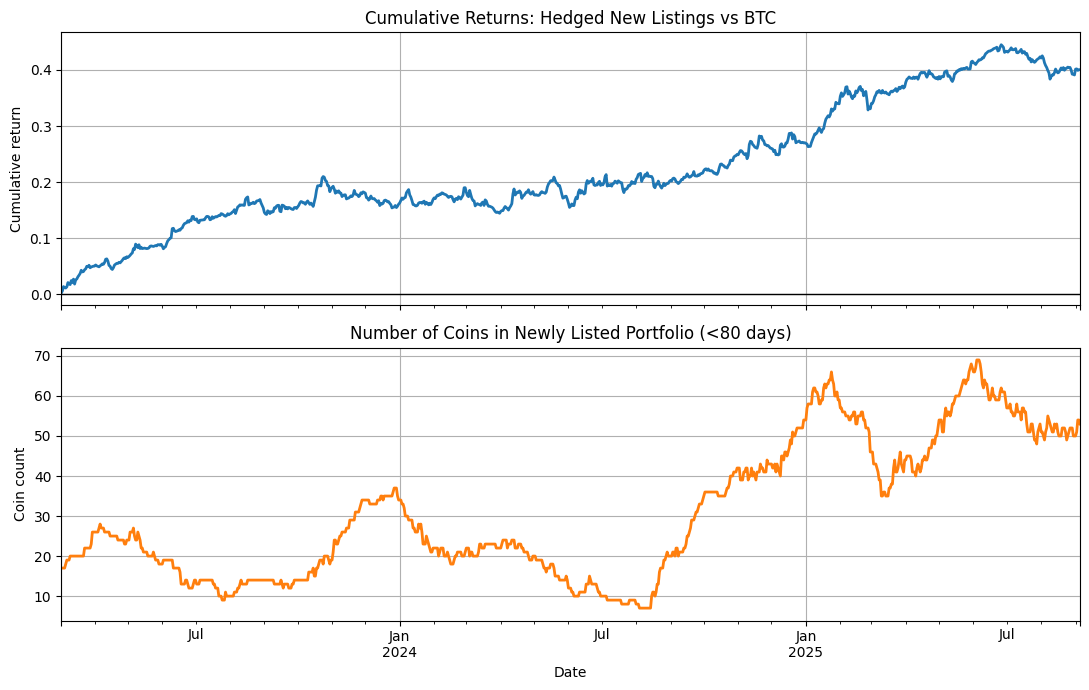

In [17]:
# ---------------- 11. Hedged equity curve ----------------
hedged_ret = (-alt_port_ret + btc_ret * beta) 

# vol scale to 10%
hedged_ret = hedged_ret * (0.10 / (hedged_ret.std() * np.sqrt(365)))

# Apply the same cutoff as df
hedged_ret = hedged_ret.loc[hedged_ret.index > '2023-03-01']

hedged_cum = hedged_ret.cumsum().rename("Hedged New Listings (equal weight)")


# ---------------- 12. Coin count ----------------
coin_count = (df['days_since_list'] < 80).groupby(df['datetime']).sum()
coin_count = coin_count.rename("newly_listed_count")

# ---------------- 13. Plot stacked ----------------
fig, axes = plt.subplots(2, 1, figsize=(11, 7), sharex=True)

# Top: hedged cumulative return
hedged_cum.plot(ax=axes[0], lw=2, color="tab:blue")
axes[0].axhline(0, color="black", lw=1)
axes[0].set_title("Cumulative Returns: Hedged New Listings vs BTC")
axes[0].set_ylabel("Cumulative return")
axes[0].grid(True)

# Bottom: # of coins
coin_count.plot(ax=axes[1], lw=2, color="tab:orange")
axes[1].set_title("Number of Coins in Newly Listed Portfolio (<80 days)")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Coin count")
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [18]:
# ---------------- 14. Performance statistics ----------------
daily_ret = hedged_ret.dropna()
n_days = len(daily_ret)
if n_days == 0:
    raise ValueError("No returns after filtering; check your date cutoff.")

# Assumption: 365 trading days per year for crypto
ann_factor = 365

# CAGR: arithmetic cum sum view, so we convert final equity to CAGR
final_equity = 1 + daily_ret.cumsum().iloc[-1]
years = (daily_ret.index[-1] - daily_ret.index[0]).days / 365
cagr = final_equity**(1/years) - 1 if years > 0 else np.nan

# Annualized volatility
vol = daily_ret.std() * np.sqrt(ann_factor)

# Sharpe ratio
sharpe = (daily_ret.mean() / daily_ret.std()) * np.sqrt(ann_factor)

# Max drawdown (on equity curve)
equity_curve = (1 + daily_ret.cumsum())
running_max = equity_curve.cummax()
drawdown = equity_curve / running_max - 1
max_dd = drawdown.min()

print(f"CAGR:   {cagr:.2%}")
print(f"Vol:    {vol:.2%}")
print(f"Sharpe: {sharpe:.2f}")
print(f"Max DD: {max_dd:.2%}")


CAGR:   14.34%
Vol:    8.41%
Sharpe: 1.89
Max DD: -5.41%
